# Doodling and drafting

In [1]:
# Importing all necessary modules and functions for the project

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import acquire
import prepare

## Acquiring the data

In [137]:
# Where to explain the env.py file? ⚠️

# Getting the telco data using the acquire function
# acquire is a function that reads in telco data from Codeup database, transforms the data into
# a csv file if a local file does not exist and saves it locally. It returns a DataFrame.

telco = acquire.get_telco_data()
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


## Examining the data for preparation step

In [24]:
# To find out the number of columns and rows in the dataset

telco.shape

(7043, 24)

In [25]:
# To print an exhaustive list of the columns and their content type as well as the possibility of null values

telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [ ]:
# The total_charges column that should have been numerical (float) has object as data type

In [140]:
# Converting to float
telco['total_charges'] = telco.total_charges.astype(float)
telco.total_charges.dtype

ValueError: could not convert string to float: ''

In [142]:
# I could not convert to float because of space in the data so I'll strip those spaces off

telco['total_charges'] = telco['total_charges'].str.strip()
telco = telco[telco.total_charges != '']

In [143]:
# I will now change it to float

telco['total_charges'] = telco.total_charges.astype(float)
telco.total_charges.dtype

dtype('float64')

In [166]:
# We have reduced the data from 7043 to 7032 rows stripping it from empty total_charges.
# These do not matter because non only do they represent a very small sample of the data
# but they may be customer who have not been billed yet and thus fall outside our scope

telco.shape

(7032, 24)

In [162]:
# Printing the content of the columns that are not displayed to have a glimpse of the data

telco[['multiple_lines', 'online_security', 'online_backup','device_protection']]

,multiple_lines,online_security,online_backup,device_protection
0,No,No,Yes,No
1,Yes,No,No,No
2,No,No,No,Yes
3,No,No,Yes,Yes
4,No,No,No,No
...,...,...,...,...
7038,No,Yes,No,No
7039,Yes,No,No,No
7040,No,No,Yes,No
7041,No,Yes,No,Yes


In [163]:
# Running a .crosstab code to see if some columns are repetitive

pd.crosstab(telco.payment_type_id, telco.payment_type)

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
payment_type_id,,,,
1,0,0,2365,0
2,0,0,0,1604
3,1542,0,0,0
4,0,1521,0,0


In [164]:
# Running a .crosstab code to see if some columns are repetitive

pd.crosstab(telco.internet_service_type, telco.internet_service_type_id)

internet_service_type_id,1,2,3
internet_service_type,,,
DSL,2416,0,0
Fiber optic,0,3096,0
None,0,0,1520


In [165]:
# Running a .crosstab code to see if some columns are repetitive

pd.crosstab(telco.contract_type_id, telco.contract_type)

contract_type,Month-to-month,One year,Two year
contract_type_id,,,
1,3875,0,0
2,0,1472,0
3,0,0,1685


In [144]:
# Producing a statistical summary of all the numeric data without distinction to look for relevant data or pattern

telco.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7032.0,2.315557,1.149523,1.00,1.0000,2.000,3.0000,4.00
internet_service_type_id,7032.0,1.872582,0.737271,1.00,1.0000,2.000,2.0000,3.00
contract_type_id,7032.0,1.688567,0.832934,1.00,1.0000,1.000,2.0000,3.00
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


In [133]:
# Plot a histogram for relevant columns

relevant_cols = telco[['monthly_charges', 'tenure', 'total_charges']]
relevant_cols

,monthly_charges,tenure,total_charges
0,65.60,9,593.30
1,59.90,9,542.40
2,73.90,4,280.85
3,98.00,13,1237.85
4,83.90,3,267.40
...,...,...,...
7038,55.15,13,742.90
7039,85.10,22,1873.70
7040,50.30,2,92.75
7041,67.85,67,4627.65


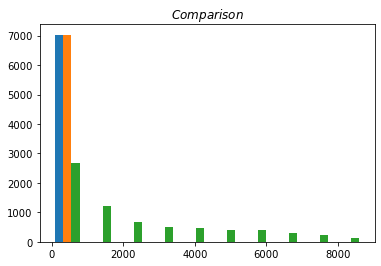

In [191]:
plt.hist(relevant_cols)
plt.title('$Comparison$')
plt.show()

In [ ]:
x1 = [randint(1, 5) for _ in range(20)]
x2 = [randint(1, 5) for _ in range(20)]

plt.hist(x1, bins=[0, 1, 2, 3, 4, 5, 6], align='left', edgecolor='black', alpha=0.5, color='blue')
plt.hist(x2, bins=[0, 1, 2, 3, 4, 5, 6], align='left', edgecolor='black', alpha=0.5, color='blue')

plt.show()


plt.hist(telco['monthly_charges'])
plt.title('$Comparison$')
plt.show()

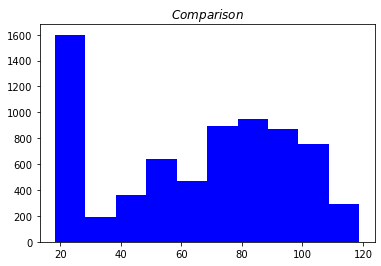

In [193]:
for col in relevant_cols:
    plt.hist(telco['monthly_charges'], color='blue')
    plt.title('$Comparison$')
    plt.show()

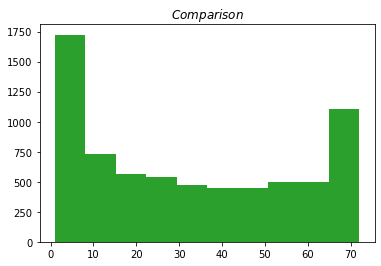

In [190]:
for col in relevant_cols:
    plt.hist(telco['tenure'])
    plt.title('$Comparison$')
    plt.show()

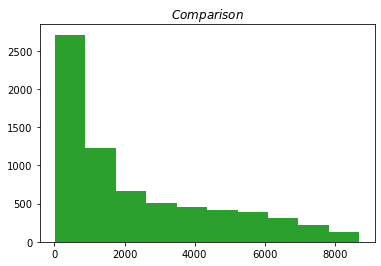

In [177]:
for col in relevant_cols:
    plt.hist(telco['total_charges'])
    plt.title('$Comparison$')
    plt.show()

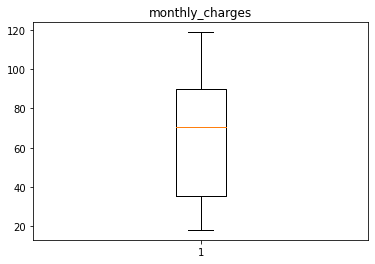

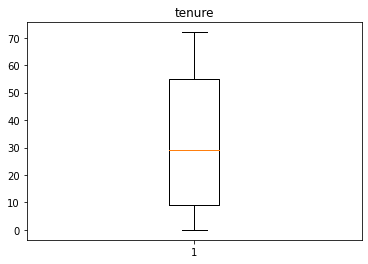

In [58]:
for col in relevant_cols:
    plt.boxplot(telco[col])
    plt.title(col)
    plt.show()

<font color='red'>**This reminded me that I can bin the tenure column and maybe the monthly payments as well**</font>

In [86]:
# What is the minimum and maximum values of tenure
min_tenure = telco.tenure.min()
max_tenure = telco.tenure.max()
min_tenure, max_tenure

(0, 72)

In [111]:
# Defining bins size
# bins = [[0,12],(12, 24], (24,36], (36, 48], (48, 60], (60, 72]]

bins = [0, 12, 24, 36, 48, 60, 72]

In [90]:
# Assigning names for the bins
bin_names = ['1year', '2years', '3years', '4years', '5years', '6years']

In [ ]:
pd.cut()

In [106]:
telco['binned_tenure'] = pd.cut(telco['tenure'], bins, labels = bin_names)
telco.head(30)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,binned_tenure
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,No,Yes,65.60,593.3,No,One year,DSL,Mailed check,1year
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,Yes,No,59.90,542.4,No,Month-to-month,DSL,Mailed check,1year
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check,1year
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check,2years
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,No,Yes,83.90,267.4,Yes,Month-to-month,Fiber optic,Mailed check,1year
5,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,69.40,571.45,No,Month-to-month,DSL,Credit card (automatic),1year
6,3,2,3,0013-SMEOE,Female,1,Yes,No,71,Yes,...,Yes,Yes,Yes,109.70,7904.25,No,Two year,Fiber optic,Bank transfer (automatic),6years
7,4,2,3,0014-BMAQU,Male,0,Yes,No,63,Yes,...,No,No,Yes,84.65,5377.8,No,Two year,Fiber optic,Credit card (automatic),6years
8,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,Yes,48.20,340.35,No,Month-to-month,DSL,Electronic check,1year
9,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check,6years


In [124]:
# How does the DataFrame registers customers with 0 tenure at telco?
telco.binned_tenure.shape

(7043,)

In [76]:
relevant_cols2 = pd.DataFrame(telco[['monthly_charges', 'tenure']])
relevant_cols2

,monthly_charges,tenure
0,65.60,9
1,59.90,9
2,73.90,4
3,98.00,13
4,83.90,3
...,...,...
7038,55.15,13
7039,85.10,22
7040,50.30,2
7041,67.85,67


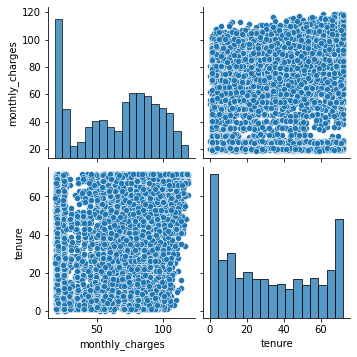

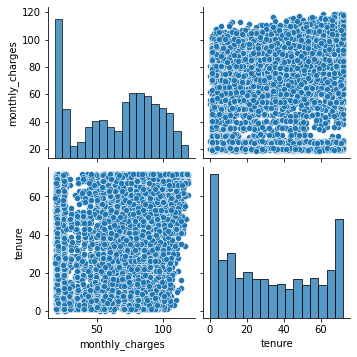

In [78]:
for col in relevant_cols2:
    sns.pairplot(relevant_cols2)

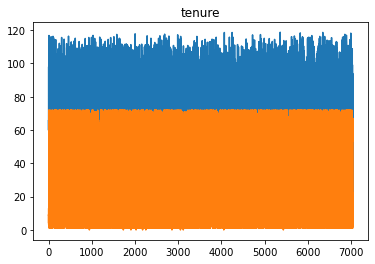

In [70]:
for col in relevant_cols:
    plt.plot(telco[col])
    plt.title(col)
    plt.show()

In [ ]:
telco.head()

In [66]:
help()


Welcome to Python 3.9's help utility!

If this is your first time using Python, you should definitely check out
the tutorial on the Internet at https://docs.python.org/3.9/tutorial/.

Enter the name of any module, keyword, or topic to get help on writing
Python programs and using Python modules.  To quit this help utility and
return to the interpreter, just type "quit".

To get a list of available modules, keywords, symbols, or topics, type
"modules", "keywords", "symbols", or "topics".  Each module also comes
with a one-line summary of what it does; to list the modules whose name
or summary contain a given string such as "spam", type "modules spam".

help> matplotlib
Help on package matplotlib:

NAME
    matplotlib - An object-oriented plotting library.

DESCRIPTION
    A procedural interface is provided by the companion pyplot module,
    which may be imported directly, e.g.::
    
        import matplotlib.pyplot as plt
    
    or using ipython::
    
        ipython
    
    at y


You are now leaving help and returning to the Python interpreter.
If you want to ask for help on a particular object directly from the
interpreter, you can type "help(object)".  Executing "help('string')"
has the same effect as typing a particular string at the help> prompt.


**The column total_charges data type is an object but it should be an integer or a float**

**Columns that are potentially significant to customer churn: All but payment_type_id,
internet_service_type_id, contract_type_id, customer_id**

**There is no null values in the dataset except for total_charges but it does not appear because they are an object type**

**The columns with _id are duplicates of other columns except for customer_id**

**Monthly charges and tenure seem to be very significant**


<font color="#ca2c92">*After observing the columns and because we are looking for costumers who have churned and I want to buikd a model that predicts churn, 
my target is going to be the churncolumn, so it will not be encoded*</font>

## Preparing the data for exploration

In [9]:
# The prepare function prepare the telco data by performing a split
# that returns train, validate, and test DataFrames, and also stratify the churn column.

# It also drops duplicate columns, null values stored as whitespace
# (customers who probably just joined and have 0 tenure), converts object datatype to float,
# converts binary categorical variables to numeric ones, gets dummies for non-binary categorical variables
# that it concatenates to the original DataFrame.

train, validate, test = prepare.prep_telco_data(telco)

In [10]:
# Displaying the content of the train subset

train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,0,0,0,1,0,0,0,1,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,0,0,0,1,0,1,0,1,0,0
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,1,0
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,0,1
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,0,1,0,0,0,0,0,1


In [13]:
train.columns.to_list()

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'gender_encoded',
 'partner_encoded',
 'dependents_encoded',
 'phone_service_encoded',
 'paperless_billing_encoded',
 'churn_encoded',
 'multiple_lines_No phone service',
 'multiple_lines_Yes',
 'online_security_No internet service',
 'online_security_Yes',
 'online_backup_No internet service',
 'online_backup_Yes',
 'device_protection_No internet service',
 'device_protection_Yes',
 'tech_support_No internet service',
 'tech_support_Yes',
 'streaming_tv_No internet service',
 'streaming_tv_Yes',
 'streaming_movies_No internet service',
 'streaming_movies_Yes',
 'contract_type_One year',
 'contract_type_Two year',
 'internet_service_type_Fi

In [11]:
# Displaying the content of the validate subset

validate.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
816,Female,0,Yes,No,27,Yes,Yes,No,No,No,...,1,0,1,0,0,1,0,1,0,0
1488,Female,0,Yes,No,71,Yes,Yes,Yes,Yes,Yes,...,1,0,1,0,1,0,0,1,0,0
4796,Male,0,No,No,44,No,No phone service,Yes,No,Yes,...,1,0,1,1,0,0,0,0,1,0
3213,Female,0,Yes,Yes,27,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,0,1,0,1,0,0,1
5026,Male,0,Yes,Yes,62,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,0,1,0,1,1,0,0


In [12]:
# Displaying the content of the test subset

test.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
3311,Female,0,No,No,29,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,1,0,0,1,0,0,1
6330,Male,0,Yes,Yes,36,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,0,1,0,1,1,0,0
6156,Male,1,No,No,1,Yes,No,No,No,No,...,0,0,0,0,0,0,0,0,1,0
5313,Male,0,No,No,25,Yes,No,No,No,No,...,0,0,0,0,0,1,0,0,1,0
1176,Female,0,Yes,No,34,Yes,No,No,No,No,...,0,0,0,0,0,0,0,0,0,0
